In [1]:
import iris
import os
from datetime import datetime
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import copy
import numpy as np
import numpy.ma as ma
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

In [2]:
# Directory containing model data on flight track and names of variables to plot
inputdir100='/shared/netscratch/mrr32/Flight_work/LiNOx_100/'
inputdir75='/shared/netscratch/mrr32/Flight_work/LiNOx_75/'
inputdir50='/shared/netscratch/mrr32/Flight_work/LiNOx_50/'
inputdir25='/shared/netscratch/mrr32/Flight_work/LiNOx_25/'
inputdir_airmass='/shared/netscratch/mrr32/Flight_work/AirMass/'

# Directory to store plots
outdir='/home/am2688/nethome/Plots/'
# colors for colorbars (from https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3):
# Diverging: blue to red (9 colours)
blue_to_red =['#313695','#4575b4','#74add1','#abd9e9','#ffffff','#fdae61','#f46d43','#d73027','#a50026'] 
# Diverging: green to magenta (9 colours)
green_to_magenta = ['#276419','#4d9221','#7fbc41','#b8e186','#ffffff','#f1b6da','#de77ae','#c51b7d','#8e0152']
# Diverging: green to purple (9 colours)
green_to_purple = ['#00441b','#1b7837','#5aae61','#a6dba0','#ffffff','#c2a5cf','#9970ab','#762a83','#40004b']
# Sequential: yellow to red (7 colours)
yellow_to_red = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
# Sequential: yellow to blue (7 colours)
yellow_to_blue=['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
# Qualitative: light blue, dark blue, light green, dark green (4 colours)
blue_green=['#a6cee3','#1f78b4','#b2df8a','#33a02c']
colour_100='#ca0020'
colour_75='#f4a582'
colour_50='#0571b0'
colour_25='#92c5de'

In [3]:
# load LiNOx emission data ------cube.coord('level_height') to acccess altitude
linox_ems_100=iris.load(inputdir100+'*.pp')
#linox_ems_75=iris.load(inputdir75+'*.pp')
#linox_ems_50=iris.load(inputdir50+'*.pp')
#linox_ems_25=iris.load(inputdir25+'*.pp')
airmass=iris.load(inputdir_airmass+'*.pp')

/home/am2688/nethome/condacf/lib/python3.9/site-packages/iris/fileformats/rules.py:353: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))


In [4]:
# calculate mean over time
time_mean_100=linox_ems_100[0].collapsed(['time'],iris.analysis.MEAN)
#time_mean_75=linox_ems_75[0].collapsed(['time'],iris.analysis.MEAN)
#time_mean_50=linox_ems_50[0].collapsed(['time'],iris.analysis.MEAN)
#time_mean_25=linox_ems_25[0].collapsed(['time'],iris.analysis.MEAN)
time_mean_airmass=airmass[0].collapsed(['time'],iris.analysis.MEAN)

/home/am2688/nethome/condacf/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/home/am2688/nethome/condacf/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_reference_time'.
  warnings.warn(msg.format(self.name()))
/home/am2688/nethome/condacf/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/home/am2688/nethome/condacf/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_reference_time'.
  warnings.warn(msg.format(self.name()))


In [5]:
# Apply a Constraint to the iris cube. See: https://scitools-iris.readthedocs.io/en/latest/userguide/subsetting_a_cube.html
tropical_constraint=iris.Constraint(latitude=lambda cell: -30 < cell < 30)


In [6]:
mass_weighted_linox=time_mean_100/time_mean_airmass

In [7]:
mass_weighted_tropics_100=mass_weighted_linox.extract(tropical_constraint)
#tropics_75=time_mean_75.extract(tropical_constraint)
#tropics_50=time_mean_50.extract(tropical_constraint)
#tropics_25=time_mean_25.extract(tropical_constraint)


In [8]:
# collapse lat and long to get a vertical profile
# (you don't need weights if you do a SUM, you might need area weights for MEAN)
mass_weighted_tropics_vp_100=mass_weighted_tropics_100.collapsed(['latitude','longitude'],iris.analysis.SUM).data

x_100=mass_weighted_tropics_vp_100

y_100=mass_weighted_tropics_100.coord('level_height').points
# convert from mol(NO2)/s to Tg(N)/yr
# g(N)=mol(N)*MW(N) ; n_sec in a year= 3.15360e+07
x_100=x_100*14.0067*1.e-12*3.15360e+07


/home/am2688/nethome/condacf/lib/python3.9/site-packages/iris/cube.py:3788: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/am2688/nethome/condacf/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/am2688/nethome/condacf/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [9]:
#convert z to km
y_100=y_100/1000

(0.0, 20.0)

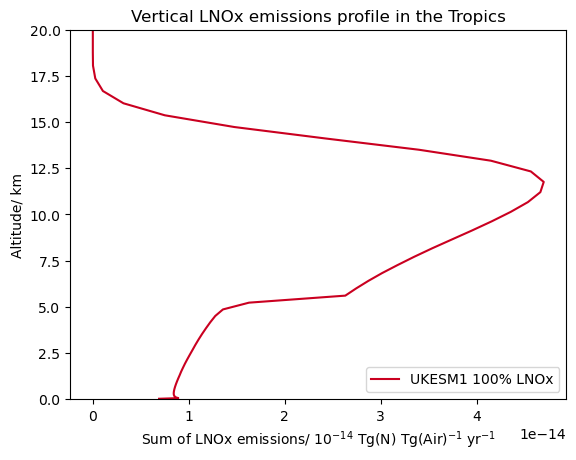

In [10]:
plt.plot(x_100, y_100, colour_100, label="UKESM1 100% LNOx")

plt.legend(loc='lower right')
plt.xlabel('Sum of LNOx emissions/ $10^{-14}$ Tg(N) Tg(Air)$^{-1}$ yr$^{-1}$')
plt.ylabel('Altitude/ km')
plt.title('Vertical LNOx emissions profile in the Tropics')
plt.ylim([0,20])
#plt.xlim([0,0.3])
#print(altitude)

#plt.savefig(outdir+'LNOx_vp_airmass.png',dpi=300,bbox_inches='tight')

In [11]:
print(x_100)

[6.89965976e-15 8.90007333e-15 8.63201112e-15 8.49874743e-15
 8.43845054e-15 8.42490140e-15 8.44510991e-15 8.49152224e-15
 8.56143125e-15 8.65265331e-15 8.76465225e-15 8.89712820e-15
 9.04942303e-15 9.20439702e-15 9.39164806e-15 9.59749231e-15
 9.83602526e-15 1.00994550e-14 1.03834178e-14 1.06773644e-14
 1.10068001e-14 1.13732876e-14 1.17830338e-14 1.22341026e-14
 1.27543045e-14 1.35538451e-14 1.62692515e-14 2.62982402e-14
 2.74385125e-14 2.87065361e-14 3.01316318e-14 3.17386295e-14
 3.34643642e-14 3.53438456e-14 3.73769382e-14 3.94763432e-14
 4.15502051e-14 4.35350540e-14 4.53179059e-14 4.66183454e-14
 4.69687562e-14 4.56260396e-14 4.14705434e-14 3.39650861e-14
 2.42655712e-14 1.47399928e-14 7.49602474e-15 3.19146895e-15
 1.05047650e-15 2.56280141e-16 1.75166811e-17 7.22525773e-19
 2.60443167e-19 6.21537761e-20 1.44074102e-20 6.64487474e-21
 7.54222654e-23 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [12]:
scale=100000000000000
test_x=x_100*scale
print(test_x)

[6.89965976e-01 8.90007333e-01 8.63201112e-01 8.49874743e-01
 8.43845054e-01 8.42490140e-01 8.44510991e-01 8.49152224e-01
 8.56143125e-01 8.65265331e-01 8.76465225e-01 8.89712820e-01
 9.04942303e-01 9.20439702e-01 9.39164806e-01 9.59749231e-01
 9.83602526e-01 1.00994550e+00 1.03834178e+00 1.06773644e+00
 1.10068001e+00 1.13732876e+00 1.17830338e+00 1.22341026e+00
 1.27543045e+00 1.35538451e+00 1.62692515e+00 2.62982402e+00
 2.74385125e+00 2.87065361e+00 3.01316318e+00 3.17386295e+00
 3.34643642e+00 3.53438456e+00 3.73769382e+00 3.94763432e+00
 4.15502051e+00 4.35350540e+00 4.53179059e+00 4.66183454e+00
 4.69687562e+00 4.56260396e+00 4.14705434e+00 3.39650861e+00
 2.42655712e+00 1.47399928e+00 7.49602474e-01 3.19146895e-01
 1.05047650e-01 2.56280141e-02 1.75166811e-03 7.22525773e-05
 2.60443167e-05 6.21537761e-06 1.44074102e-06 6.64487474e-07
 7.54222654e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

(0.0, 5.0)

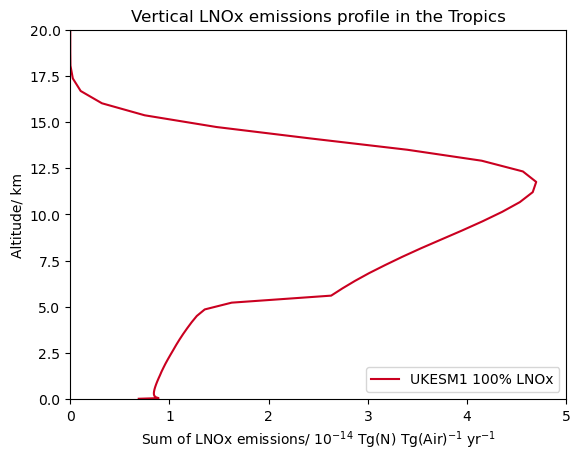

In [13]:
plt.plot(test_x, y_100, colour_100, label="UKESM1 100% LNOx")

plt.legend(loc='lower right')
plt.xlabel('Sum of LNOx emissions/ $10^{-14}$ Tg(N) Tg(Air)$^{-1}$ yr$^{-1}$')
plt.ylabel('Altitude/ km')
plt.title('Vertical LNOx emissions profile in the Tropics')
plt.ylim([0,20])
plt.xlim([0,5])
#print(altitude)

#plt.savefig(outdir+'LNOx_vp_airmass.png',dpi=300,bbox_inches='tight')

In [14]:
print(y_100)
type(y_100)

[1.99999977e-02 5.33333346e-02 1.00000039e-01 1.59999996e-01
 2.33333334e-01 3.19999993e-01 4.19999957e-01 5.33333361e-01
 6.59999967e-01 7.99999952e-01 9.53333676e-01 1.12000000e+00
 1.30000019e+00 1.49333346e+00 1.70000005e+00 1.91999948e+00
 2.15333295e+00 2.39999986e+00 2.65999937e+00 2.93333292e+00
 3.21999979e+00 3.51999950e+00 3.83333349e+00 4.16000032e+00
 4.49999952e+00 4.85333347e+00 5.21999931e+00 5.59999943e+00
 5.99333286e+00 6.39999962e+00 6.81999969e+00 7.25333309e+00
 7.69999933e+00 8.16000080e+00 8.63333988e+00 9.12000656e+00
 9.62001991e+00 1.01333685e+01 1.06600790e+01 1.12001610e+01
 1.17536383e+01 1.23205462e+01 1.29009342e+01 1.34948807e+01
 1.41024771e+01 1.47238789e+01 1.53592367e+01 1.60088158e+01
 1.66729031e+01 1.73519001e+01 1.80462914e+01 1.87567024e+01
 1.94838867e+01 2.02287750e+01 2.09925270e+01 2.17765083e+01
 2.25823917e+01 2.34121628e+01 2.42681789e+01 2.51532249e+01
 2.60705872e+01 2.70241089e+01 2.80182610e+01 2.90582256e+01
 3.01500168e+01 3.130053

numpy.ndarray